In [51]:
import malariagen_data
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numba

In [2]:
TAXON_PALETTE = px.colors.qualitative.Vivid
TAXON_COLORS = {
    "gambiae": TAXON_PALETTE[1],
    "coluzzii": TAXON_PALETTE[0],
    "arabiensis": TAXON_PALETTE[2],
    "merus": TAXON_PALETTE[3],
    "melas": TAXON_PALETTE[4],
    "quadriannulatus": TAXON_PALETTE[5],
    "fontenillei": TAXON_PALETTE[6],
    "gcx1": TAXON_PALETTE[7],
    "gcx2": TAXON_PALETTE[8],
    "gcx3": TAXON_PALETTE[9],
    "gcx4": TAXON_PALETTE[10],
    "unassigned": "black",
}

### GWSS

In [3]:
ag3 = malariagen_data.Ag3(
            gcs_cache="../../gcs_cache/", 
            results_cache="../../results_cache/"
)

In [4]:
sample_set = "1244-VO-GH-YAWSON-VMF00149"

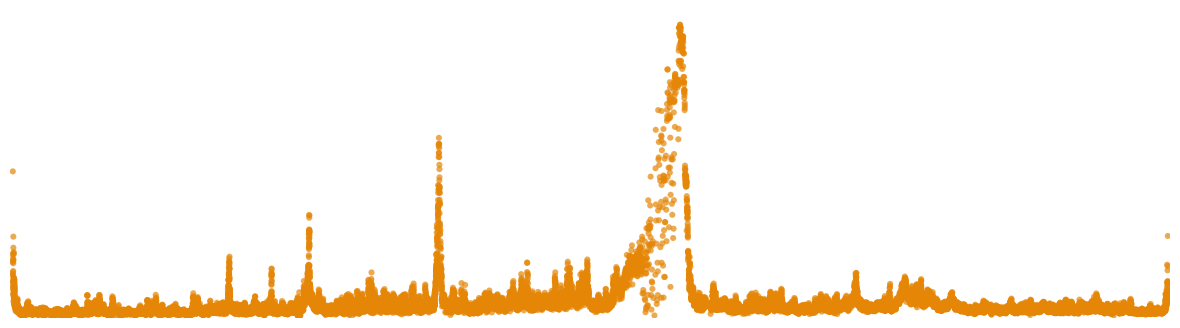

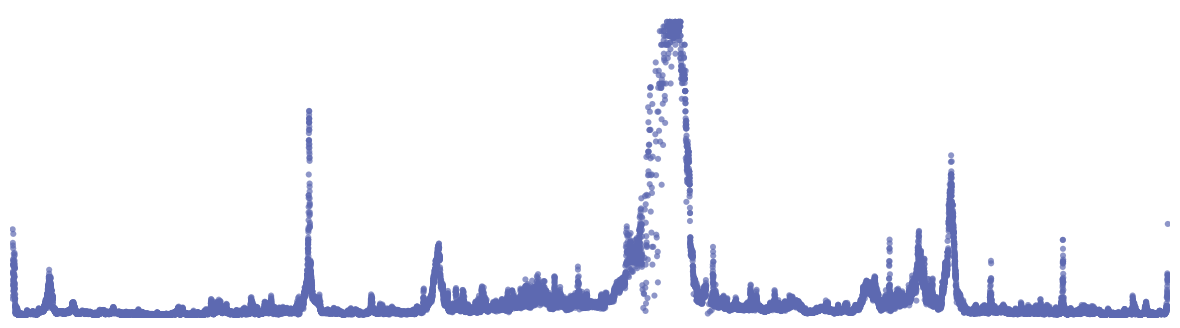

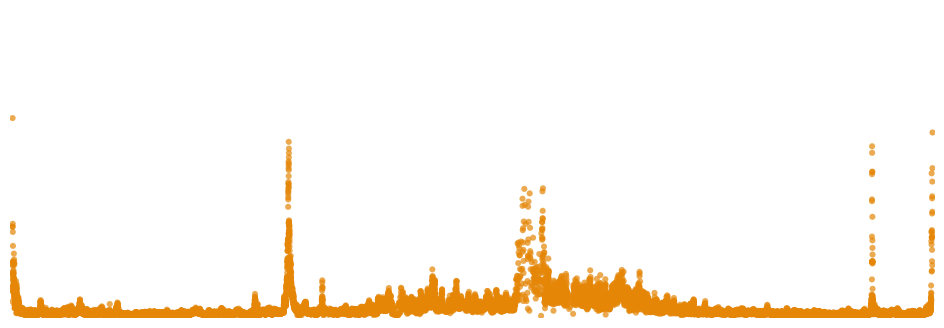

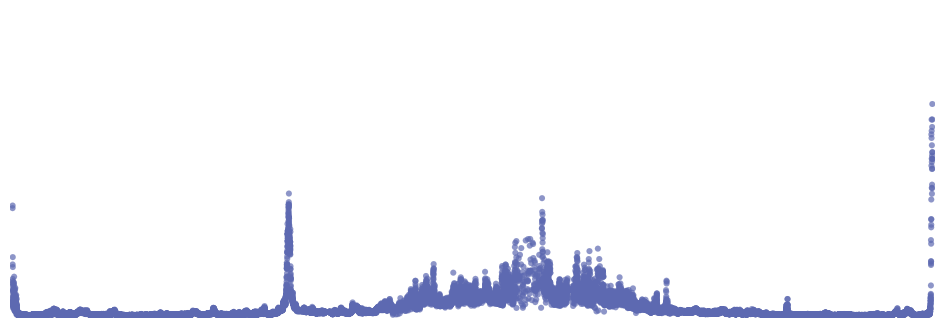

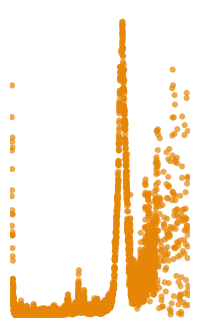

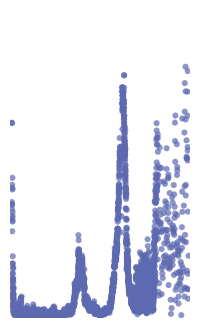

In [71]:
# Assuming you have your data in 'x' and 'y' variables
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

def plot_h_stat(x, y, title, hue):

    fig, ax = plt.subplots(figsize=[x.shape[0]/2000, 4])

    sns.scatterplot(x=x, y=y,ax=ax, size=100, alpha=0.7, color=hue, edgecolor=None, linewidth=0.1)
    ax.set_xlim(0-250000, x.max() + 250000)
    ax.set_ylim(0,1.04)
    # xtick = np.arange(0, x.max(), 10000000)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_clip_on(False)
    # ax.set_xticklabels(['{:,.0f}'.format(x_val) for x_val in xtick])
    # Rotate the x-tick labels by 45 degrees
    # plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    sns.despine(left=True, bottom=True)
    ax.get_legend().remove()
    plt.savefig(f"{title}.png", dpi=500, pad_inches=0)

@numba.njit
def hampel_filter(x, size, t=3):
    # https://link.springer.com/article/10.1186/s13634-016-0383-6
    # https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d
    
    y = x.copy()
    mad_scale_factor = 1.4826
    
    for i in range(size, len(x) - size):
        # window
        w = x[i - size:i + size]
        # window median
        m = np.median(w)
        # median absolute deviation
        mad = np.median(np.abs(w - m))
        # MAD scale estimate
        s = mad_scale_factor * mad
        # construct response
        if np.abs(x[i] - m) > (t * s):
            y[i] = m
    
    return y

for contig in ['2RL', '3RL', 'X']:
    
    for taxon in ['coluzzii', 'gambiae']:

        x, y = ag3.h12_gwss(
                    contig=contig,
                    window_size=1000, 
                    sample_sets=sample_set, 
                    sample_query=f"taxon == '{taxon}'",
                    max_cohort_size=100,
                )

        if taxon == 'gambiae':
            hue = np.repeat('#5D69B1', len(x))
        else: 
            hue = np.repeat('#E58606', len(x))

        # filter outliers
        filter_size = 20  # hampel filter parameter
        filter_t = 2  # hampel filter parameter
        h12_filtered = hampel_filter(y, size=filter_size, t=filter_t)
        
        plot_h_stat(x=x, y=h12_filtered, hue=hue, title=f'h12_{contig}_{taxon}')

In [63]:
def plot_h1x(x, y, title, hue):

    fig, ax = plt.subplots(figsize=[x.shape[0]/2000, 1])

    sns.lineplot(x=x, y=y,ax=ax, alpha=0.7, color=hue, linewidth=1)
    ax.fill_between(x, y, color=hue, alpha=0.7)
    plt.title(f"{title}", fontsize=16)
    ax.set_xlim(0-10000, x.max() + 10000)
    ax.set_ylim(0,1)
    # xtick = np.arange(0, x.max(), 10000000)
    ax.set_xticks([])
    # ax.set_xticklabels(['{:,.0f}'.format(x_val) for x_val in xtick])
    # Rotate the x-tick labels by 45 degrees
    # plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.savefig(f"{title}.png", dpi=500, bbox_inches='tight')

ValueError: All arrays must be of the same length

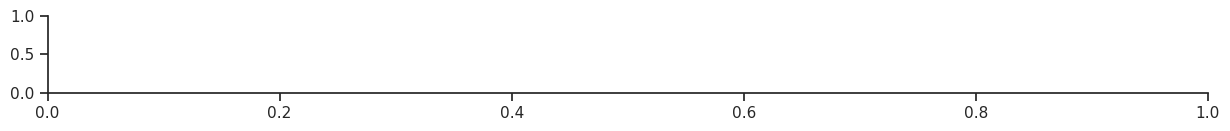

In [60]:
for contig in ['2RL', '3RL', 'X']:

    x_h1x, h1x = ag3.h1x_gwss(
            contig=contig,
            window_size=1000, 
            sample_sets=sample_set, 
            cohort1_query=f"taxon == 'gambiae'",
            cohort2_query=f"taxon == 'coluzzii'",
            max_cohort_size=100,
        )
    
    plot_h1x(x=x_h1x, y=h1x, title=f'h1x_{contig}', hue='black')